In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
# import data 
df = pd.read_csv("predator-prey-data.csv", delimiter = ",")
t = np.array(df["t"])
x = df["x"]
y = df["y"]

In [3]:
def lotka_volterra(init, t, alpha, beta, delta, gamma):
    x, y = init
    dxdt = alpha * x - beta * x * y 
    dydt = delta * x * y - gamma * y
    return dxdt, dydt

In [ ]:
def abs_residual(params,data):
    x = data['x']
    y = data['y']
    x_and_y = np.vstack((x,y)).T
    t = np.array(data['t'])
    
    y0 = [x[0], y[0]]
    time = np.linspace(t[0],t[-1],len(t))
    model = odeint(lotka_volterra, y0, time, args=(params[0], params[1], params[2], params[3]))
    return np.linalg.norm(model - x_and_y)**2

In [20]:
def loss_function_res(params, data):
    t_data = np.array(data['t'], dtype=float)
    x = np.array(data['x'], dtype=float)
    y = np.array(data['y'], dtype=float)
    y0 = [x[0], y[0]]
    t = np.linspace(t_data[0], t_data[-1], num=len(t_data))
    output = odeint(lotka_volterra, y0, t, args=(params[0], params[1], params[2], params[3]))

    loss = 0
    for i in range(len(t)):
        x_data = x[i]
        x_model = output[i,0]

        y_data = y[i]
        y_model = output[i,1]

        res = (x_data - x_model)**2 + (y_data - y_model)**2
        loss += res
    return loss

In [21]:
def hill_climber(data, initial_params, step_size, iterations):
    best_params = initial_params
    prev_params = best_params*2
    best_loss = loss_function_res(initial_params, data)
    print(best_loss)
    
    while best_params.any != prev_params.any:
        prev_params = best_params
        print(f"prev: {prev_params}")
        for i in range(iterations):
            init_par = initial_params
            # Generate a random perturbation to the parameters
            new_params = []
            for param in init_par:
                new_param = param + np.random.normal(0,step_size)
                new_params.append(new_param)
            
            new_params = np.array(new_params)
            # Calculate the loss for the new parameters
            new_loss = loss_function_res(new_params, data)
            
            # Update if the new parameters give a better loss
            if new_loss < best_loss:
                best_loss = new_loss
                best_params = new_params
    
    return best_params, best_loss

In [189]:
import random 
# init_guess = np.ones(4)
# print(init_guess)

init_guess = []
for i in range(4):
    init_guess.append(random.uniform(0, 5))
  
init_guess = np.array(init_guess)
print(init_guess)
min_function = loss_function_res
step_size = 0.5
iterations = 10
data = df

params, loss = hill_climber(data, init_guess, step_size, iterations)

print(params, loss)

[1.88483722 1.86046056 0.66516506 1.52184885]
1566.7809976994185
prev: [1.88483722 1.86046056 0.66516506 1.52184885]
prev: [1.78056212 1.84075775 1.4601372  1.44628773]
prev: [2.19893856 1.79327262 0.96332589 1.00783912]
prev: [2.20607929 0.9499259  0.36404267 1.01098175]
prev: [2.12835524 1.26987859 0.57335578 0.77830722]
[2.12835524 1.26987859 0.57335578 0.77830722] 786.2902200341789


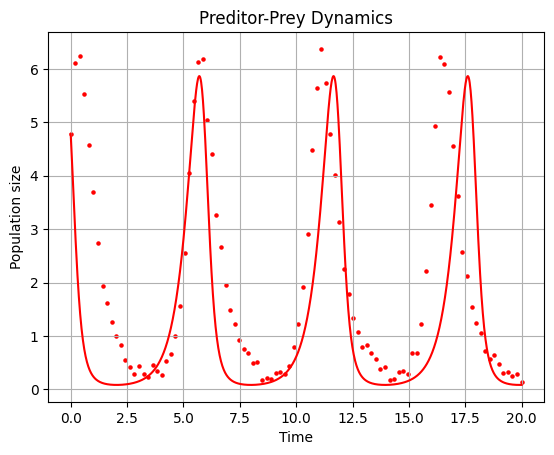

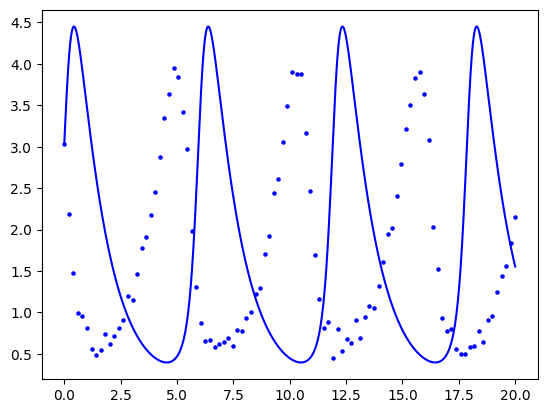

In [190]:
alpha_sim = params[0]
beta_sim = params[1]
delta_sim = params[2]
gamma_sim = params[3]

y0 = [x[0], y[0]]
t = np.linspace(t[0], t[-1], num=1000)

output = odeint(lotka_volterra, y0, t, args=(alpha_sim, beta_sim, delta_sim, gamma_sim))

plt.title("Preditor-Prey Dynamics")
plt.ylabel("Population size")
plt.xlabel("Time")
plt.grid()

plt.plot(t,output[:,0], color="r")
plt.scatter(df["t"], df["x"], color = 'r', s = 5, label = 'x (prey)')

plt.show()

plt.plot(t,output[:,1], color="b")
plt.scatter(df["t"], df["y"], color = 'b', s = 5, label = 'x (predator)')

plt.show()